In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm
import pop_tools

def pop_find_lat_ind(loc, LATDAT):
    return np.abs(LATDAT[:, 0].values - loc).argmin()

def pop_find_lon_ind(loc, LONDAT, direction="w"):
    if direction.lower() in ["east", "e"]:
        value = loc
    elif direction.lower() in ["west", "w"]:
        value = 360 - loc
    else:
        print("I do not know which direction.")
    return np.nanargmin(np.abs(LONDAT[0, :].values - value))

# open sample data
ds_ctl = xr.open_dataset(r'D:\CESM_output\output\TAbias_Kt_C_ctl-30y\data\TAbias_Kt_C_ctl-30y_avg_26-30.nc')

# get lola inds from somewhere for indexing later on
lola_inds = {}
inds_lat = range(-89, 90, 1)
for j in inds_lat:
    if j < 0:
        lola_inds["j_" + str(j)[1:] + "s"] = pop_find_lat_ind(j, ds_ctl.TLAT)
    else:
        lola_inds["j_" + str(j) + "n"] = pop_find_lat_ind(j, ds_ctl.TLAT)

inds_lon = range(0, 360, 1)
for i in inds_lon:
    lola_inds["i_" + str(i) + "_w"] = pop_find_lon_ind(i, ds_ctl.TLONG)

DZT = np.zeros((60,384,320))

for k in range(60):
            DZT[k,:,:] = ds_ctl.dz[k]

ds2 = xr.Dataset({'DZT': (['z_t','nlat','nlon',], DZT),
                   'DZU': (['z_t','nlat','nlon'], DZT)},
                    coords={'TLAT': (['nlat','nlon'],ds_ctl.TLAT),
                            'TLONG': (['nlat','nlon'],ds_ctl.TLONG),
                            'ULAT': (['nlat','nlon'],ds_ctl.ULAT),
                            'ULONG': (['nlat','nlon'],ds_ctl.ULONG),
                            'z_t': (['z_t'],ds_ctl.z_t)})


In [2]:
#%%
ds_ctl["DZT"] = ds2.DZT
ds_ctl["DZU"] = ds2.DZU

ds_ctl.DZT.attrs["long_name"] = "Thickness of T cells"
ds_ctl.DZT.attrs["units"] = "centimeter"
ds_ctl.DZT.attrs["grid_loc"] = "3111"
ds_ctl.DZU.attrs["long_name"] = "Thickness of U cells"
ds_ctl.DZU.attrs["units"] = "centimeter"
ds_ctl.DZU.attrs["grid_loc"] = "3221"

# make sure we have the cell volumne for calculations
VOL = (ds_ctl.DZT * ds_ctl.DXT * ds_ctl.DYT).compute()
KMT = ds_ctl.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds_ctl["VOL"] = VOL

ds_ctl.VOL.attrs["long_name"] = "volume of T cells"
ds_ctl.VOL.attrs["units"] = "centimeter^3"
ds_ctl.VOL.attrs["grid_loc"] = "3111"

budget = xr.Dataset()
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}
gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    ds_ctl,
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)
  
for coord in ["nlat", "nlon"]:
    if coord in dsxgcm.coords:
        dsxgcm = dsxgcm.drop_vars(coord)

budget['TEND_TEMP'] = dsxgcm.TEND_TEMP
budget['RF_TEND_TEMP'] = dsxgcm.RF_TEND_TEMP

budget["UET"] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
budget["VNT"] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)
budget["WTT"] = (
    gridxgcm.diff(dsxgcm.WTT.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL
)

budget["TOT_ADV"] = budget["UET"] + budget["VNT"] + budget["WTT"]

budget["DIA_IMPVF_TEMP"] = -(
    gridxgcm.diff(dsxgcm.DIA_IMPVF_TEMP * dsxgcm.TAREA, axis="Z") / dsxgcm.VOL
)

# set surface flux at 0th layer
SRF_TEMP_FLUX = (dsxgcm.SHF - dsxgcm.SHF_QSW) * dsxgcm.hflux_factor

budget["DIA_IMPVF_TEMP"][:, 0, :, :] = (
    SRF_TEMP_FLUX * dsxgcm.TAREA - dsxgcm.DIA_IMPVF_TEMP.isel(z_w_bot=0) * dsxgcm.TAREA
) / dsxgcm.VOL.values[0, :, :]

budget["KPP_SRC_TMP"] = dsxgcm.KPP_SRC_TEMP
budget["VDIF"] = budget["DIA_IMPVF_TEMP"] + budget["KPP_SRC_TMP"]

budget["HDIFE_TEMP"] = gridxgcm.diff(dsxgcm.HDIFE_TEMP * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL
budget["HDIFN_TEMP"] = gridxgcm.diff(dsxgcm.HDIFN_TEMP * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL
budget["HDIFB_TEMP"] = -gridxgcm.diff(dsxgcm.HDIFB_TEMP * dsxgcm.VOL.values, axis="Z") / dsxgcm.VOL
budget["HDIFB_TEMP"][:, 0, :, :] = -dsxgcm.HDIFB_TEMP.isel(z_w_bot=0)

budget["HDIF"] = budget["HDIFE_TEMP"] + budget["HDIFN_TEMP"] + budget["HDIFB_TEMP"]

budget["QSW_3D"] = -gridxgcm.diff((dsxgcm.QSW_3D * dsxgcm.hflux_factor), axis="Z") / dsxgcm.DZT


100%|██████████| 384/384 [00:00<00:00, 1206.98it/s]


In [36]:
subset_ctl = budget.isel(nlon_t=lola_inds["i_45_w"], nlat_t=lola_inds["j_10n"], time=0)

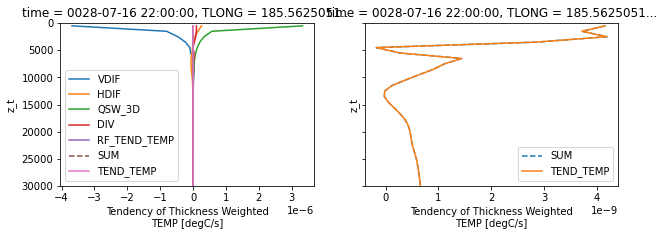

In [35]:
subset_ctl = budget.isel(nlon_t=200, nlat_t=100, time=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# plot individual components
subset_ctl.VDIF.plot(y="z_t", ylim=(300e2, 0), label="VDIF", ax=ax[0])
subset_ctl.HDIF.plot(y="z_t", ylim=(300e2, 0), label="HDIF", ax=ax[0])
subset_ctl.QSW_3D.plot(y="z_t", ylim=(300e2, 0), label="QSW_3D", ax=ax[0])
subset_ctl.TOT_ADV.plot(y="z_t", ylim=(300e2, 0), label="DIV", ax=ax[0])
subset_ctl.RF_TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="RF_TEND_TEMP", ax=ax[0])

# plot sum
(subset_ctl.QSW_3D + subset_ctl.HDIF + subset_ctl.VDIF + subset_ctl.TOT_ADV + subset_ctl.RF_TEND_TEMP).plot(
    y="z_t", ylim=(300e2, 0), label="SUM", ls="--", ax=ax[0]
)
# plot tendency
subset_ctl.TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="TEND_TEMP", ax=ax[0])

ax[0].legend()

# plot sum
(subset_ctl.QSW_3D + subset_ctl.HDIF + subset_ctl.VDIF + subset_ctl.TOT_ADV + subset_ctl.RF_TEND_TEMP).plot(
    y="z_t", ylim=(300e2, 0), label="SUM", ls="--", ax=ax[1]
)
# plot tendency
subset_ctl.TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="TEND_TEMP", ax=ax[1])

ax[1].legend()  

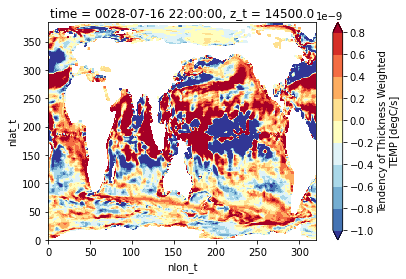

In [12]:
budget.TEND_TEMP.isel(z_t=14).plot(levels=np.arange(-1e-9,1e-9,2e-10),cmap="RdYlBu_r") 

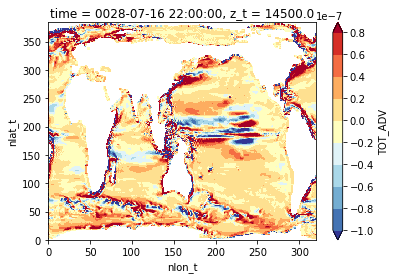

In [20]:
budget.TOT_ADV.isel(z_t=14).plot(levels=np.arange(-1e-7,1e-7,2e-8),cmap="RdYlBu_r") 

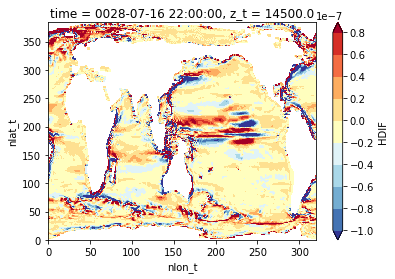

In [21]:
budget.HDIF.isel(z_t=14).plot(levels=np.arange(-1e-7,1e-7,2e-8),cmap="RdYlBu_r") 

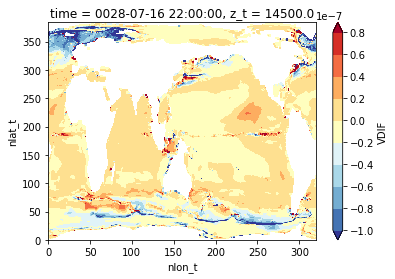

In [22]:
budget.VDIF.isel(z_t=14).plot(levels=np.arange(-1e-7,1e-7,2e-8),cmap="RdYlBu_r") 

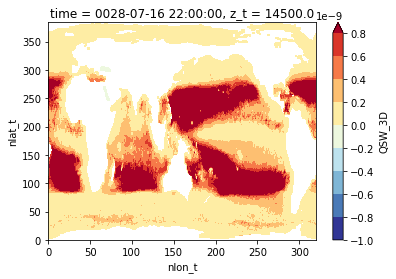

In [27]:
budget.QSW_3D.isel(z_t=14).plot(levels=np.arange(-1e-9,1e-9,2e-10),cmap="RdYlBu_r") 

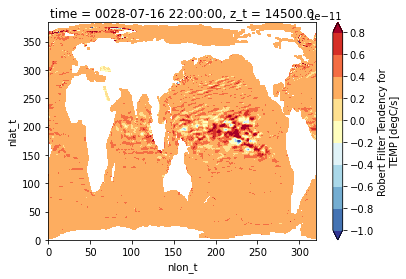

In [34]:
budget.RF_TEND_TEMP.isel(z_t=14).plot(levels=np.arange(-1e-11,1e-11,2e-12),cmap="RdYlBu_r") 